# TP13 (Students version): link prediction with rankings

We can use the following libraries.

In [7]:
import matplotlib.pyplot as plt
import math
import sys
import random
import time
import copy
print(sys.version)

3.8.10 (default, Nov 26 2021, 20:14:08) 
[GCC 9.3.0]


## Data

The dataset that we use is an old online social network of hamster lovers called *hamsterer*. The links of the dataset are friendship links among users. Download from the NAM webpage the datasets :

- hamsterer_train.txt , this is the training dataset that we use to order pairs of nodes (roughly 90% of the full data)

- hamsterer_test.txt , this is the test dataset that is the set of "missing links" that we are supposed to discover using a link prediction method (roughly 10% of the data).

You can load both datasets as dictionary of lists as usual.

In [8]:
def remove_loop_dupes(graph):
    for node in graph:
        graph[node] = list(dict.fromkeys(graph[node]))
        try:
            graph[node].remove(node)
        except ValueError:
            pass

def graph_from_file(file_name):
    graph = {}
    with open(file_name, "r") as graph_file:
        for line in graph_file:
            try:
                node1, node2 = [int(node) for node in line.split()]
                if node1 not in graph:
                    graph[node1] = []
                graph[node1].append(node2)
                if node2 not in graph:
                    graph[node2]= []
                graph[node2].append(node1)
            except:
                pass
    remove_loop_dupes(graph)
    return graph

In [9]:
test_set = graph_from_file("res/hamsterer_test.txt")
train_set = graph_from_file("res/hamsterer_train.txt")

## Exercise 1: Features for link prediction

### Question 1

- Make a function that, given a pair of nodes $ (i,j) $ in the network, computes the number of Common Neighbors (CN) between these two nodes.

- Do the same thing for the preferential attachment index of $ (i,j) $, we remind that
$$ PA(i,j) = |N(i)|.|N(j)| $$

- Do the same thing for the Adamic-Adar index of $ (i,j) $, we remind that
$$ AA(i,j) = \sum _{k \in N(i) \cap N(j)} \frac{1}{log(d_k)} $$

Here $ N(i) $ is the neighborhood of node $i$ and $ d_k $ the degree of node $k$.

In [10]:
def compute_CN(i, j, graph):
    return len(set(graph[i]).intersection(graph[j]))

def compute_PA(i,j, graph):
    return len(graph[i]) * len(graph[j])

def compute_AA(i,j, graph):
    return sum([1 / math.log(len(graph[node])) for node in set(graph[i]).intersection(graph[j])])

In [11]:
compute_CN(237,238,train_set)

164

In [12]:
compute_PA(490,492, train_set)

1281

In [13]:
compute_AA(490,492,train_set)

2.393282274671158

### Question 2

Select 10000 pairs of nodes randomly in the training dataset.

- Plot the corresponding data points in a $PA$ vs $CN$ space with a red point if the edge exists and a blue point if it doesn't (as in the course). It is relevant here to use a logscale for the $PA$ axis (for readability purposes).

- How many connected pairs do you observe with this plot? What is the name of the phenomenon that we have described in the course and that this plot shows?

- Do you think that a $k$-nearest neighbor method would work well with these features? Why?

In [14]:
def plot_PA_CN(train_set):
    nodes = list(train_set.keys())
    pa_exist,cn_exist = [], []
    pa_not, cn_not = [], []
    for i in range(10000):
        node1, node2 = random.choice(nodes), random.choice(nodes)
        pa, cn = compute_PA(node1, node2, train_set), compute_CN(node1, node2, train_set)
        if node1 in train_set[node2]:
            pa_exist.append(pa) ; cn_exist.append(cn)
        else:
            pa_not.append(pa) ; cn_not.append(cn)
    plt.xscale("log")
    plt.scatter(pa_not, cn_not, color = "blue")   
    plt.scatter(pa_exist, cn_exist, color = "red")
    print(len(pa_exist))


68


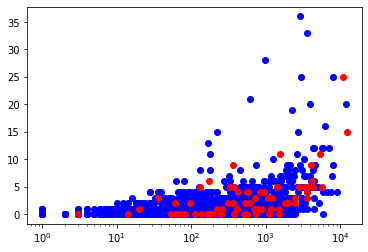

In [15]:
plot_PA_CN(train_set)

We see around 70 connected pairs in the plot.
The name of the phenomenon is overfitting.


## Exercise 2: Ranking to predict links

### Question 3

Write functions that allows to rank pairs of nodes by decreasing score for the four scores computed above: $CN$, $PA$, $J$ and $AA$.

**Warning**: even if our dataset is rather small, we need to optimize this computation, otherwise it will be too long: we only compute the scores of pairs at distance exactly 2 (if the distance is 1 these nodes are already connected, if the distance is > 2, they share no neighbors).


In [16]:
def rank(train_set, compute_score):
    scores = {}
    for node1 in train_set:
        for node2 in train_set[node1]:
            for node3 in train_set[node2]:
                if node3 > node1:
                    scores[(node1, node3)] = compute_score(node1, node3, train_set)
    scores = sorted(scores.items(), key=lambda x : x[1], reverse=True)
    return dict(scores)
                    

In [17]:
cn_ranks = rank(train_set, compute_CN)
pa_ranks = rank(train_set, compute_PA)
aa_ranks = rank(train_set, compute_AA)

### Question 4

- For a given number of predictions $T$ on a given ranking, make a function that computes the Precision and Recall for this prediction. We remind that

$$ Pr = \frac{\# tp}{\# predictions}$$ 

$$ Rc = \frac{\# tp}{\# connected \ pairs \ to \ discover} $$

- Try the following values for $T$: [1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000] and plot the corresponding curve in the recall-precision space for the *CN*, *PA* and *AA* index and also for a random ordering. 

- Which index seems to be the most efficient with these data? Does it correspond to the example of the course? Do you see any explanation for that?

In [18]:
def compute_precision_recall(prediction_count, ranking, test_set):
    predictions, tp = list(ranking.keys())[:prediction_count], 0
    for node1, node2 in predictions:
        if node2 in test_set and node1 in test_set[node2]:
            tp += 1
    return tp / prediction_count, tp / len(test_set)
    
def plot_recall_precision(T, ranking, test_set, legend):
    precisions = []
    recalls = []
    for t in T:
        precision, recall = compute_precision_recall(t, ranking, test_set)
        precisions.append(precision)
        recalls.append(recall)
    plt.plot(precisions, recalls, label=legend)
    plt.legend()
    

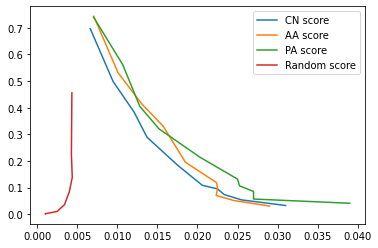

In [19]:
T = [1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000] 
plot_recall_precision(T, cn_ranks, test_set, "CN score")
plot_recall_precision(T, aa_ranks, test_set, "AA score")
plot_recall_precision(T, pa_ranks, test_set, "PA score")
random_ranks = list(pa_ranks.items())
random.shuffle(random_ranks)
random_ranks = dict(random_ranks)
plot_recall_precision(T, random_ranks, test_set, "Random score")



With these data, the most efficient seems to be the PA score, it achieved a precision of 0.040 and a recall of 0.75 whereas the other score go around a precision of around 0.030 and a recall of 0.70